# LIKWID DVFS profile parser

Parse LIKWID `.prof` files in `tests/SPEChpc/IntelSPR/job-submit/DVFS/profiles`,
aggregate metrics across sockets, and plot a selected field.


In [46]:
# User inputs
benchmark_name = 'tealeaf'

In [47]:
from __future__ import annotations

from pathlib import Path
from typing import Dict, List, Sequence

import matplotlib.pyplot as plt
import pandas as pd

SUM_FIELDS = {
    'Energy [J]',
    'Power [W]',
    'Energy PP0 [J]',
    'Power PP0 [W]',
    'Energy DRAM [J]',
    'Power DRAM [W]',
    'Energy PLATFORM [J]',
    'Power PLATFORM [W]',
    'Memory read bandwidth [MBytes/s]',
    'Memory read data volume [GBytes]',
    'Memory write bandwidth [MBytes/s]',
    'Memory write data volume [GBytes]',
    'Memory bandwidth [MBytes/s]',
    'Memory data volume [GBytes]',
    'L3 request rate',
    'L3 miss rate',
    'L3 miss ratio',
}


def find_dvfs_dir(start: Path) -> Path:
    current = start.resolve()
    for _ in range(6):
        if (current / 'profiles').is_dir():
            return current
        if current.parent == current:
            break
        current = current.parent
    raise FileNotFoundError('Could not find a folder containing profiles/.')


def extract_job_id(path: Path | str) -> str:
    name = path.name if isinstance(path, Path) else Path(path).name
    parts = name.split('.')
    if len(parts) < 3:
        raise ValueError(f'Could not infer job id from {name}')
    return parts[-2]


def _stdout_candidates(folder: Path, job_id: str) -> List[Path]:
    pattern = f'*.{job_id}.out'
    matches = sorted(folder.rglob(pattern))
    return [
        path
        for path in matches
        if 'timeline' not in path.name and not path.name.startswith('likwid_')
    ]


def find_stdout_for_job(dvfs_dir: Path, job_id: str) -> Path:
    search_roots = [dvfs_dir, dvfs_dir.parent]
    candidates: List[Path] = []
    for root in search_roots:
        if root.exists():
            candidates.extend(_stdout_candidates(root, job_id))
    if not candidates:
        raise FileNotFoundError(f'No stdout file found for job {job_id} under {dvfs_dir.parent}')
    candidates = sorted(candidates)
    if len(candidates) > 1:
        print(f'Multiple stdout candidates found; using {candidates[0]}')
    return candidates[0]


def parse_headers(stdout_path: Path) -> List[Sequence[str]]:
    headers: List[Sequence[str]] = []
    with stdout_path.open() as handle:
        for line in handle:
            if line.startswith('# GID|'):
                parts = line.lstrip('#').strip().split('|')
                fields = parts[3:]
                if fields:
                    headers.append(fields)
    if not headers:
        raise RuntimeError(f'No LIKWID headers found in {stdout_path}')
    return headers


def aggregate_metric(values: Sequence[float], field: str) -> float:
    if not values:
        raise KeyError(f'Missing values for field {field}')
    if field in SUM_FIELDS:
        return float(sum(values))
    return float(sum(values) / len(values))


def load_likwid_profile(profile_path: Path, stdout_path: Path, *, skip_initial: int = 0) -> pd.DataFrame:
    headers = parse_headers(stdout_path)
    if len(headers) > 1:
        print(f'Warning: expected 1 header set, found {len(headers)} in {stdout_path.name}')
    header = headers[0]
    global_field = header[0]
    metric_fields = header[1:]

    rows: List[Dict[str, float]] = []
    with profile_path.open() as handle:
        for raw_line in handle:
            line = raw_line.strip()
            if not line or not line[0].isdigit():
                continue
            parts = line.split(',')
            if len(parts) < 4:
                continue
            gid = int(parts[0])
            metrics_count = int(parts[1])
            cpu_count = int(parts[2])
            values = [float(val) for val in parts[3:]]

            if metrics_count != len(metric_fields):
                raise ValueError(
                    f'Header mismatch: expected {len(metric_fields)} metrics, got {metrics_count} in {profile_path.name}'
                )

            expected_values = 1 + metrics_count * cpu_count
            if len(values) != expected_values:
                raise ValueError(
                    f'Expected {expected_values} numeric entries, got {len(values)} in {profile_path.name}'
                )

            global_value = values[0]
            metric_values = values[1:]

            extracted: Dict[str, float] = {global_field: global_value}
            for idx, field in enumerate(metric_fields):
                start = idx * cpu_count
                end = start + cpu_count
                segment = metric_values[start:end]
                if not segment:
                    continue
                extracted[field] = aggregate_metric(segment, field)

            extracted['gid'] = gid
            rows.append(extracted)

    if not rows:
        raise RuntimeError(f'No LIKWID samples parsed from {profile_path.name}')

    if skip_initial:
        rows = rows[skip_initial:]

    df = pd.DataFrame(rows).reset_index(drop=True)
    df.index.name = 'sample_index'
    return df


def plot_metric(df: pd.DataFrame, metric_to_plot: str, *, y_limits: tuple[float, float] | None = None) -> None:
    if metric_to_plot not in df.columns:
        raise ValueError(f"Metric '{metric_to_plot}' not found. Choose one of: {sorted(df.columns)}")

    time_axis = df['Total runtime [s]'] if 'Total runtime [s]' in df.columns else df.index
    time_label = 'Total runtime [s]' if 'Total runtime [s]' in df.columns else 'Sample index'

    plt.figure(figsize=(10, 4))
    plt.plot(time_axis, df[metric_to_plot], marker='')
    plt.xlabel(time_label)
    plt.ylabel(metric_to_plot)
    plt.title(f'{metric_to_plot} across LIKWID samples')
    if y_limits is not None:
        plt.ylim(*y_limits)
    plt.grid(True)
    plt.tight_layout()


In [48]:
# Auto-detect the DVFS-style folder by looking for profiles/ above the notebook location.
dvfs_dir = find_dvfs_dir(Path.cwd())
profiles_dir = dvfs_dir / 'profiles'


In [49]:
# List available profiles and select the newest one for the benchmark.
profile_paths = sorted(profiles_dir.glob('spechpc_*.prof'))
profile_table = []
for path in profile_paths:
    parts = path.stem.split('.')
    name = parts[0].removeprefix('spechpc_')
    job = parts[1] if len(parts) > 1 else ''
    profile_table.append({'benchmark': name, 'job_id': job, 'path': path})

profiles_df = pd.DataFrame(profile_table).sort_values(['benchmark', 'job_id'])
profiles_df

match = profiles_df[profiles_df['benchmark'] == benchmark_name]
if match.empty:
    raise ValueError(f'No profiles found for benchmark {benchmark_name}')

match = match.sort_values('job_id')
profile_file = Path(match.iloc[-1]['path'])
job_id = extract_job_id(profile_file)
stdout_file = find_stdout_for_job(dvfs_dir, job_id)

print('Selected profile:', profile_file)
print('Stdout:', stdout_file)


Multiple stdout candidates found; using /mnt/REPACSS/home/li29729/Research2025/CPUfreq/PrimeMicroBenchmarks/tests/SPEChpc/IntelSPR/job-submit/DVFS/518.tealeaf_t/spechpc_tealeaf.28262.out
Selected profile: /mnt/REPACSS/home/li29729/Research2025/CPUfreq/PrimeMicroBenchmarks/tests/SPEChpc/IntelSPR/job-submit/DVFS/profiles/spechpc_tealeaf.28262.prof
Stdout: /mnt/REPACSS/home/li29729/Research2025/CPUfreq/PrimeMicroBenchmarks/tests/SPEChpc/IntelSPR/job-submit/DVFS/518.tealeaf_t/spechpc_tealeaf.28262.out


In [50]:
skip_initial = 3  # drop the first N samples if they are noisy
df = load_likwid_profile(profile_file, stdout_file, skip_initial=skip_initial)
df.head()


,Total runtime [s],Runtime (RDTSC) [s],Runtime unhalted [s],Clock [MHz],CPI,Temperature [C],Energy [J],Power [W],Energy PP0 [J],Power PP0 [W],Energy DRAM [J],Power DRAM [W],Energy PLATFORM [J],Power PLATFORM [W],gid
sample_index,,,,,,,,,,,,,,,
0,1.500114,0.498915,56294.409638,2500.027313,1.000000,45.0,106.523071,213.509543,0.0,0.0,9.993630,20.030735,0.015198,0.030462,1
1,2.000125,0.499148,0.000641,1276.168111,1.186245,45.0,101.709900,203.767188,0.0,0.0,9.696621,19.426361,0.014832,0.029714,1
2,2.500104,0.498420,0.035430,2410.397729,0.719216,46.0,110.032227,220.761917,0.0,0.0,9.758597,19.579051,0.015442,0.030982,1
3,3.000138,0.499452,0.288247,2493.553616,0.754873,48.0,154.245422,308.829569,0.0,0.0,24.031255,48.115283,0.019348,0.038739,1
4,3.500147,0.499449,0.361388,1914.330621,1.817723,48.0,166.436462,333.240238,0.0,0.0,39.056653,78.199501,0.020996,0.042039,1


In [51]:
# Runtime, average power, energy, and EDP
required_fields = [
    'Power [W]',
    'Power DRAM [W]',
    'Power PLATFORM [W]',
]
missing = [field for field in required_fields if field not in df.columns]
if missing:
    raise ValueError(f"Missing columns for power/energy calculations: {missing}")

if 'Total runtime [s]' in df.columns:
    time_axis = df['Total runtime [s]']
    total_runtime = float(time_axis.iloc[-1])
else:
    time_axis = df.index
    total_runtime = float(time_axis[-1] - time_axis[0]) if len(time_axis) > 1 else 0.0

time_values = time_axis.to_numpy()
cpu_power = df['Power [W]'].to_numpy()
dram_power = df['Power DRAM [W]'].to_numpy()
platform_power = df['Power PLATFORM [W]'].to_numpy()

avg_cpu_power = float(df['Power [W]'].mean())
avg_dram_power = float(df['Power DRAM [W]'].mean())
avg_platform_power = float(df['Power PLATFORM [W]'].mean())
avg_total_power = avg_cpu_power + avg_dram_power + avg_platform_power

if len(time_values) > 1:
    dt = time_values[1:] - time_values[:-1]
    total_cpu_energy = float((cpu_power[:-1] + cpu_power[1:]).dot(dt) / 2.0)
    total_dram_energy = float((dram_power[:-1] + dram_power[1:]).dot(dt) / 2.0)
    total_platform_energy = float((platform_power[:-1] + platform_power[1:]).dot(dt) / 2.0)
else:
    total_cpu_energy = 0.0
    total_dram_energy = 0.0
    total_platform_energy = 0.0

total_energy = total_cpu_energy + total_dram_energy + total_platform_energy
edp = total_energy * total_runtime

print(f'Total runtime [s]: {total_runtime:.3f}')
print(f'Average CPU Power [W]: {avg_cpu_power:.3f}')
print(f'Average DRAM power [W]: {avg_dram_power:.3f}')
print(f'Average Power PLATFORM [W]: {avg_platform_power:.3f}')
print(f'Average total power [W]: {avg_total_power:.3f}')
print(f'Total CPU energy [J]: {total_cpu_energy:.3f}')
print(f'Total DRAM energy [J]: {total_dram_energy:.3f}')
print(f'Total PLATFORM energy [J]: {total_platform_energy:.3f}')
print(f'Total energy [J]: {total_energy:.3f}')
print(f'EDP [J*s]: {edp:.3f}')


Total runtime [s]: 490.008
Average CPU Power [W]: 331.049
Average DRAM power [W]: 78.546
Average Power PLATFORM [W]: 0.042
Average total power [W]: 409.638
Total CPU energy [J]: 161781.738
Total DRAM energy [J]: 38400.112
Total PLATFORM energy [J]: 20.585
Total energy [J]: 200202.435
EDP [J*s]: 98100778.758


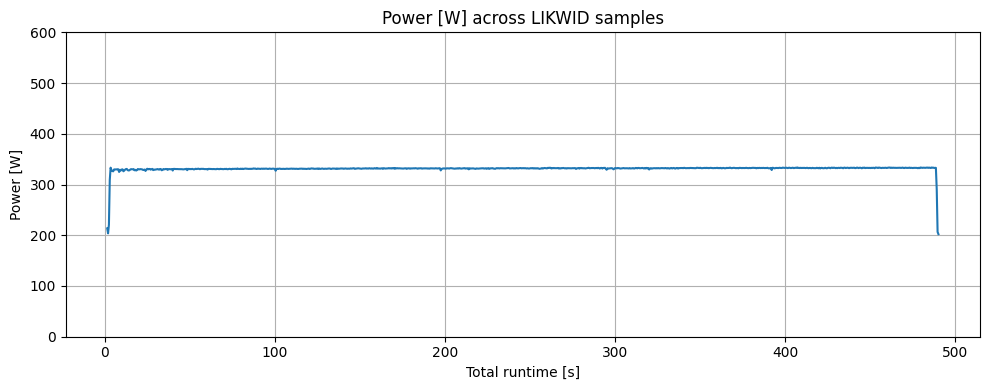

In [52]:
metric_to_plot = 'Power [W]'
plot_metric(df, metric_to_plot, y_limits=(0, 600))


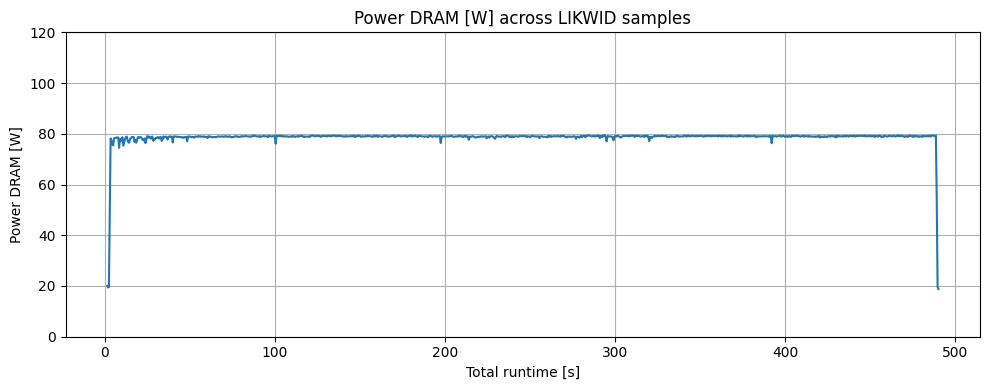

In [53]:
metric_to_plot = "Power DRAM [W]"
plot_metric(df, metric_to_plot, y_limits=(0, 120))

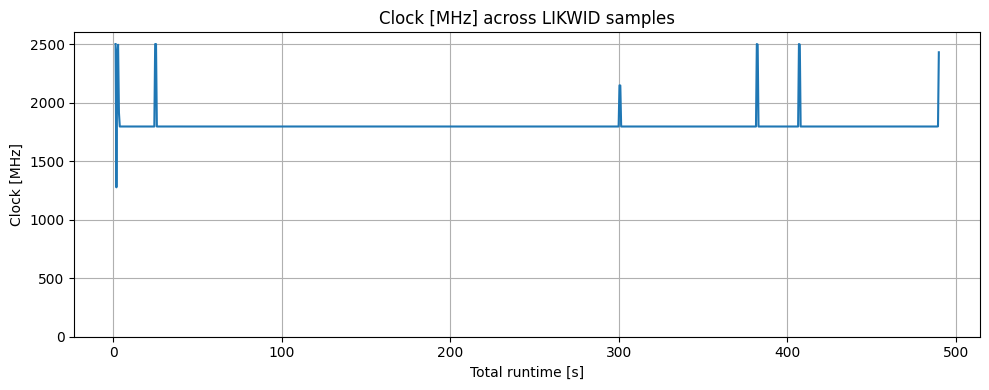

In [54]:
metric_to_plot = "Clock [MHz]"
plot_metric(df, metric_to_plot, y_limits=(0, 2600))